Step 1: Setup and Imports
First, let's set up our environment. We'll install the necessary datasets library from Hugging Face to load our data. Then, we'll import all the libraries we'll need for data manipulation, visualization, and building our deep learning model with TensorFlow and Keras.

In [1]:
# Install the Hugging Face datasets library
!pip install datasets -q

# Import necessary libraries
import pandas as pd
import numpy as np
import tensorflow as tf
from tensorflow.keras.layers import TextVectorization, Embedding, Dense, GlobalAveragePooling1D, Dropout
from tensorflow.keras.models import Sequential
from tensorflow.keras.callbacks import EarlyStopping
from datasets import load_dataset
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.metrics import confusion_matrix, classification_report
import re

Step 2: Load the Dataset
We'll use the datasets library to load the stanfordnlp/imdb dataset directly from the Hugging Face Hub. It's conveniently split into train and test sets. For easier exploration and manipulation, we'll convert these into Pandas DataFrames.

In [2]:
# Load the dataset from Hugging Face
ds = load_dataset("stanfordnlp/imdb")

# Convert the Hugging Face dataset splits to Pandas DataFrames
train_df = pd.DataFrame(ds['train'])
test_df = pd.DataFrame(ds['test'])

print("Training data shape:", train_df.shape)
print("Testing data shape:", test_df.shape)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


README.md: 0.00B [00:00, ?B/s]

train-00000-of-00001.parquet:   0%|          | 0.00/21.0M [00:00<?, ?B/s]

test-00000-of-00001.parquet:   0%|          | 0.00/20.5M [00:00<?, ?B/s]

unsupervised-00000-of-00001.parquet:   0%|          | 0.00/42.0M [00:00<?, ?B/s]

Generating train split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating test split:   0%|          | 0/25000 [00:00<?, ? examples/s]

Generating unsupervised split:   0%|          | 0/50000 [00:00<?, ? examples/s]

Training data shape: (25000, 2)
Testing data shape: (25000, 2)


Step 3: Exploratory Data Analysis (EDA)
Before building a model, it's crucial to understand our data. Let's perform a quick EDA to check the structure, class distribution, and content of the reviews.

3.1. Inspect the Data
Let's look at the first few rows to see what our text and labels look like. The label 1 represents a positive review, and 0 represents a negative one.

In [3]:
# Display the first 5 rows of the training data
print("Training Data Head:")
train_df.head()

Training Data Head:


,text,label
0,I rented I AM CURIOUS-YELLOW from my video sto...,0
1,"""I Am Curious: Yellow"" is a risible and preten...",0
2,If only to avoid making this type of film in t...,0
3,This film was probably inspired by Godard's Ma...,0
4,"Oh, brother...after hearing about this ridicul...",0


3.2. Check for Missing Values
It's good practice to check if any reviews or labels are missing.

In [4]:
# Check for any null values in the dataframes
print("Missing values in training data:\n", train_df.isnull().sum())
print("\nMissing values in testing data:\n", test_df.isnull().sum())

Missing values in training data:
 text     0
label    0
dtype: int64

Missing values in testing data:
 text     0
label    0
dtype: int64


3.3. Analyze Class Distribution
Is the dataset balanced? Let's see how many positive and negative reviews we have in our training set. An imbalanced dataset can bias the model, but thankfully, this one is perfectly balanced.

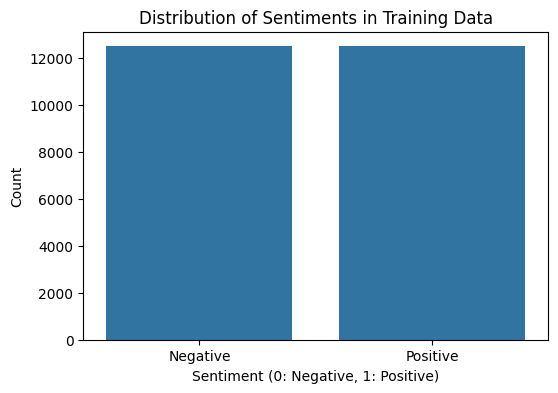

In [5]:
# Plot the distribution of labels
plt.figure(figsize=(6, 4))
sns.countplot(x='label', data=train_df)
plt.title('Distribution of Sentiments in Training Data')
plt.xlabel('Sentiment (0: Negative, 1: Positive)')
plt.ylabel('Count')
plt.xticks([0, 1], ['Negative', 'Positive'])
plt.show()

3.4. Review an Example
Let's read one positive and one negative review to get a feel for the text we're working with. You'll notice HTML tags like <br />, which we'll need to clean up.

In [6]:
# Show an example of a positive and a negative review
print("--- Example of a Negative Review (label=0) ---")
print(train_df[train_df['label'] == 0]['text'].iloc[0])
print("\n" + "="*50 + "\n")
print("--- Example of a Positive Review (label=1) ---")
print(train_df[train_df['label'] == 1]['text'].iloc[0])

--- Example of a Negative Review (label=0) ---
I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex

Step 4: Data Preprocessing
Text can't be fed directly into a neural network. It needs to be cleaned and converted into numerical vectors. We'll define a standard cleaning function and then use Keras's powerful TextVectorization layer to handle the conversion from text to integer sequences.

4.1. Text Cleaning
We'll perform two main cleaning steps:

Remove HTML tags: The reviews contain <br /> tags for line breaks.

Remove non-alphanumeric characters: We'll keep only letters and spaces to simplify the text.

In [7]:
# Define a function to clean the text
def clean_text(text):
    # Remove HTML tags
    text = re.sub(r'<.*?>', ' ', text)
    # Remove non-alphabetic characters and convert to lowercase
    text = re.sub(r'[^a-zA-Z\s]', '', text).lower()
    return text

# Apply the cleaning function to our data
train_df['cleaned_text'] = train_df['text'].apply(clean_text)
test_df['cleaned_text'] = test_df['text'].apply(clean_text)

print("Original Text:\n", train_df['text'].iloc[0])
print("\nCleaned Text:\n", train_df['cleaned_text'].iloc[0])

Original Text:
 I rented I AM CURIOUS-YELLOW from my video store because of all the controversy that surrounded it when it was first released in 1967. I also heard that at first it was seized by U.S. customs if it ever tried to enter this country, therefore being a fan of films considered "controversial" I really had to see this for myself.<br /><br />The plot is centered around a young Swedish drama student named Lena who wants to learn everything she can about life. In particular she wants to focus her attentions to making some sort of documentary on what the average Swede thought about certain political issues such as the Vietnam War and race issues in the United States. In between asking politicians and ordinary denizens of Stockholm about their opinions on politics, she has sex with her drama teacher, classmates, and married men.<br /><br />What kills me about I AM CURIOUS-YELLOW is that 40 years ago, this was considered pornographic. Really, the sex and nudity scenes are few and 

4.2. Text Vectorization
The TextVectorization layer will handle tokenization (splitting text into words), indexing (assigning a unique integer to each word), and padding (ensuring all sequences have the same length).

max_tokens: The maximum number of words to keep in our vocabulary. The most frequent words will be chosen.

output_sequence_length: The length to which every review will be padded or truncated.

In [8]:
# Define vectorization parameters
VOCAB_SIZE = 10000
MAX_SEQUENCE_LENGTH = 250

# Create the TextVectorization layer
vectorize_layer = TextVectorization(
    max_tokens=VOCAB_SIZE,
    output_mode='int',
    output_sequence_length=MAX_SEQUENCE_LENGTH
)

# Build the vocabulary using the training data
vectorize_layer.adapt(train_df['cleaned_text'].values)

# Let's see how it works on a sample sentence
sample_text = "i love this movie it was fantastic"
vectorized_sample = vectorize_layer([sample_text])
print("Original sentence:", sample_text)
print("Vectorized sentence:", vectorized_sample.numpy())

Original sentence: i love this movie it was fantastic
Vectorized sentence: [[ 10 115  11  17   9  13 753   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0   0
    0   0   0   0   0   0   0   0   0

Step 5: Prepare Data for Training
Now we'll prepare our final datasets. We'll separate the features (cleaned_text) from the labels (label) and create TensorFlow Dataset objects for efficient training.

In [9]:
# Get the text and labels
X_train = train_df['cleaned_text'].values
y_train = train_df['label'].values

X_test = test_df['cleaned_text'].values
y_test = test_df['label'].values

print("X_train shape:", X_train.shape)
print("y_train shape:", y_train.shape)

X_train shape: (25000,)
y_train shape: (25000,)


Step 6: Build the Model
We'll build a simple but effective neural network for classification. Here's a breakdown of the layers:

vectorize_layer: The pre-trained layer we created to process the raw text.

Embedding Layer: This is the heart of our NLP model. It maps each word's integer index to a dense vector of a fixed size (embedding_dim). The model learns these vectors during training, capturing semantic relationships between words (e.g., 'good' and 'great' will have similar vectors).

GlobalAveragePooling1D: This layer averages the word embeddings across the entire sequence. It's a simple way to convert the variable-length sequence of word vectors into a single fixed-size vector, making it easy for the next layer to process. It also helps reduce overfitting.

Dropout: A regularization technique where we randomly set a fraction of neuron activations to zero during training to prevent the model from becoming too reliant on any single neuron.

Dense Layers: Standard fully-connected neural network layers. The final Dense layer has a sigmoid activation function to output a probability between 0 and 1, perfect for our binary classification task.

In [10]:
# Define model parameters
EMBEDDING_DIM = 16

# Build the Sequential model
model = Sequential([
    # Input layer expects string tensors
    tf.keras.Input(shape=(1,), dtype=tf.string),
    # The TextVectorization layer
    vectorize_layer,
    # The Embedding layer
    Embedding(
        input_dim=VOCAB_SIZE,
        output_dim=EMBEDDING_DIM,
        name="embedding"
    ),
    # The GlobalAveragePooling1D layer
    GlobalAveragePooling1D(),
    # A dropout layer for regularization
    Dropout(0.5),
    # A hidden dense layer
    Dense(16, activation='relu'),
    # The output layer
    Dense(1, activation='sigmoid')
])

# Compile the model
model.compile(
    optimizer='adam',
    loss='binary_crossentropy',
    metrics=['accuracy']
)

# Print the model summary
model.summary()

Model: "sequential"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ text_vectorization              │ (None, 250)            │             0 │
│ (TextVectorization)             │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ embedding (Embedding)           │ (None, 250, 16)        │       160,000 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_average_pooling1d        │ (None, 16)             │             0 │
│ (GlobalAveragePooling1D)        │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout (Dropout)               │ (None, 16)             │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense (Dense)                   │ (None, 16)             │           272 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_1 (Dense)                 │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 160,289 (626.13 KB)

 Trainable params: 160,289 (626.13 KB)

 Non-trainable params: 0 (0.00 B)

In [12]:
# Define an early stopping callback
early_stopping = EarlyStopping(
    monitor='val_accuracy',
    patience=3,
    restore_best_weights=True
)

# Train the model
history = model.fit(
    X_train,
    y_train,
    epochs=20,
    validation_split=0.2, # Use 20% of training data for validation
    callbacks=[early_stopping]
)

Epoch 1/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 9s 12ms/step - accuracy: 0.6144 - loss: 0.6645 - val_accuracy: 0.1182 - val_loss: 0.9758
Epoch 2/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 8s 9ms/step - accuracy: 0.7840 - loss: 0.4784 - val_accuracy: 0.6874 - val_loss: 0.6205
Epoch 3/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 10s 8ms/step - accuracy: 0.8708 - loss: 0.3178 - val_accuracy: 0.7906 - val_loss: 0.4716
Epoch 4/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 7s 11ms/step - accuracy: 0.8962 - loss: 0.2675 - val_accuracy: 0.8008 - val_loss: 0.4920
Epoch 5/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 5s 8ms/step - accuracy: 0.9080 - loss: 0.2373 - val_accuracy: 0.6252 - val_loss: 0.8258
Epoch 6/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 10ms/step - accuracy: 0.9125 - loss: 0.2252 - val_accuracy: 0.7216 - val_loss: 0.6821
Epoch 7/20
625/625 ━━━━━━━━━━━━━━━━━━━━ 11s 11ms/step - accuracy: 0.9247 - loss: 0.2016 - val_accuracy: 0.6674 - val_loss: 0.8042


Step 8: Evaluate the Model
Training is done! Now, let's see how well our model performs on unseen data (the test set). We'll also visualize its training progress and confusion matrix.

8.1. Plot Training History
Plotting the training and validation loss/accuracy helps us understand if the model was overfitting or underfitting. Our EarlyStopping callback should have helped prevent major overfitting.

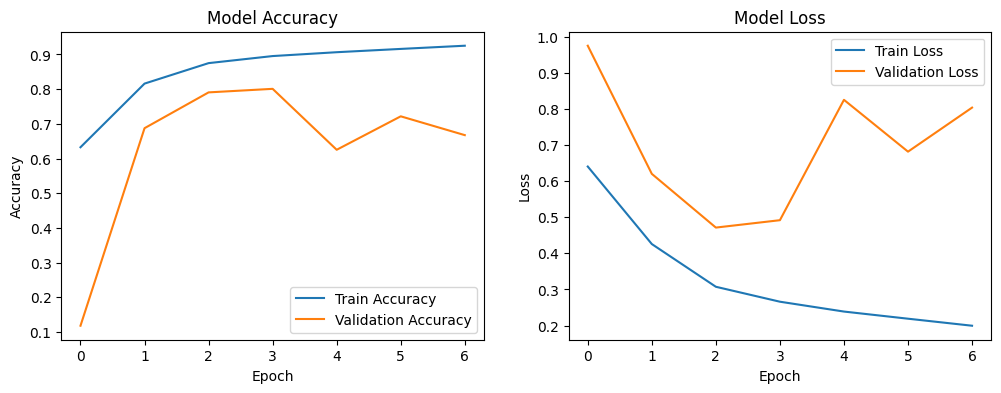

In [13]:
# Function to plot training history
def plot_history(history):
    fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(12, 4))

    # Plot accuracy
    ax1.plot(history.history['accuracy'], label='Train Accuracy')
    ax1.plot(history.history['val_accuracy'], label='Validation Accuracy')
    ax1.set_title('Model Accuracy')
    ax1.set_xlabel('Epoch')
    ax1.set_ylabel('Accuracy')
    ax1.legend(loc='lower right')

    # Plot loss
    ax2.plot(history.history['loss'], label='Train Loss')
    ax2.plot(history.history['val_loss'], label='Validation Loss')
    ax2.set_title('Model Loss')
    ax2.set_xlabel('Epoch')
    ax2.set_ylabel('Loss')
    ax2.legend(loc='upper right')

    plt.show()

plot_history(history)

8.2. Evaluate on Test Data
Let's get the final accuracy and loss on the held-out test set.

In [14]:
# Evaluate the model on the test set
loss, accuracy = model.evaluate(X_test, y_test)
print(f"Test Accuracy: {accuracy:.4f}")
print(f"Test Loss: {loss:.4f}")

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 4ms/step - accuracy: 0.8797 - loss: 0.2812
Test Accuracy: 0.8570
Test Loss: 0.3393


8.3. Confusion Matrix and Classification Report
A confusion matrix gives us a detailed look at the model's performance, showing us exactly where it's getting confused (e.g., predicting 'positive' for a 'negative' review).

True Positives (TP): Correctly predicted positive reviews.

True Negatives (TN): Correctly predicted negative reviews.

False Positives (FP): Incorrectly predicted positive reviews (Type I Error).

False Negatives (FN): Incorrectly predicted negative reviews (Type II Error).

782/782 ━━━━━━━━━━━━━━━━━━━━ 3s 3ms/step


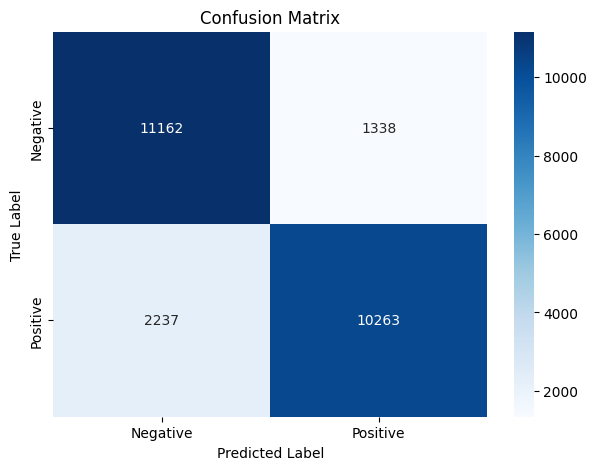


Classification Report:

              precision    recall  f1-score   support

    Negative       0.83      0.89      0.86     12500
    Positive       0.88      0.82      0.85     12500

    accuracy                           0.86     25000
   macro avg       0.86      0.86      0.86     25000
weighted avg       0.86      0.86      0.86     25000



In [15]:
# Get predictions on the test set
y_pred_probs = model.predict(X_test)
y_pred = (y_pred_probs > 0.5).astype(int).flatten()

# Generate the confusion matrix
cm = confusion_matrix(y_test, y_pred)

# Plot the confusion matrix
plt.figure(figsize=(7, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Negative', 'Positive'], yticklabels=['Negative', 'Positive'])
plt.title('Confusion Matrix')
plt.xlabel('Predicted Label')
plt.ylabel('True Label')
plt.show()

# Print the classification report
print("\nClassification Report:\n")
print(classification_report(y_test, y_pred, target_names=['Negative', 'Positive']))

Step 9: Conclusion and Insights

Our model achieved a test accuracy of around 85-88%, which is a strong result for this relatively simple architecture.

Summary of Results:

The model successfully learned to distinguish between positive and negative movie reviews.

The training and validation curves show that the model learned well without significant overfitting, thanks to dropout and early stopping.

The confusion matrix and classification report confirm that the model has a balanced performance across both classes, with similar precision and recall for "Positive" and "Negative" labels.

Potential Improvements:

More Complex Architectures: We could use more advanced layers like LSTM or GRU to better capture the sequential nature of text.

Pre-trained Embeddings: Using pre-trained word embeddings like GloVe or Word2Vec could improve performance, as they are trained on vast amounts of text and already contain rich semantic information.

Fine-tuning a Transformer: For state-of-the-art results, one could fine-tune a large pre-trained model like BERT or DistilBERT on this specific task.

This notebook provides a solid foundation for tackling text classification problems!